In [23]:
import pymongo
import pickle
import redis
import matplotlib.pyplot as plt
%matplotlib inline
import wikipedia
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import pprint
pp = pprint.PrettyPrinter(indent=1)

rcparams = {'legend.fontsize': 'large',
          'figure.figsize': (10,8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.labelweight' : 'bold',
         'axes.titleweight' : 'bold'}
plt.rcParams.update(rcparams)


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

from wikipedia_helper import *

## Downloading articles

In [2]:
mgclient = pymongo.MongoClient('54.202.56.110')
wikipedia_db = mgclient.database_names()
article_collector = mgclient.wikipedia_db.article_collector
if mgclient.wikipedia_db.article_collector.count() != 0:
    mgclient.wikipedia_db.drop_collection(article_collector)
    test_collector = mgclient.wikipedia_db.article_collector

wiki_categories = [line.rstrip('\n') for line in open('list_of_categories.txt')]
wiki_categories = [line.split(':')[2] for line in wiki_categories]

pageid_title_df, subcat_dict, uncollected_articles = get_article_category_pageid_titles(wiki_categories,article_collector)

r = redis.StrictRedis('54.202.56.110')
subcat_dict = pickle.dumps(subcat_dict)
pageid_title_df = pickle.dumps(pageid_title_df)
uncollected_articles = pickle.dumps(uncollected_articles)
r.set('subcat_dict',subcat_dict)
r.set('pageid_title_df',pageid_title_df)
r.set('uncollected_articles',uncollected_articles)

100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [05:51<00:00,  1.76s/it]


number of articles found: 195
number of articles stored: 195 




100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [05:08<00:00,  1.74s/it]


number of articles found: 175
number of articles stored: 370 




100%|████████████████████████████████████████████████████████████████████████████████| 304/304 [09:03<00:00,  1.68s/it]


number of articles found: 304
number of articles stored: 671 




100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [01:16<00:00,  1.84s/it]


number of articles found: 41
number of articles stored: 712 




100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [03:11<00:00,  1.90s/it]


number of articles found: 109
number of articles stored: 820 




100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:49<00:00,  1.70s/it]


number of articles found: 29
number of articles stored: 849 




100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [14:46<00:00,  1.83s/it]


number of articles found: 500
number of articles stored: 1343 




100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:58<00:00,  1.71s/it]


number of articles found: 200
number of articles stored: 1542 




100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [06:15<00:00,  1.69s/it]


number of articles found: 215
number of articles stored: 1756 




100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [05:01<00:00,  1.68s/it]


number of articles found: 176
number of articles stored: 1932 




100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [02:10<00:00,  1.87s/it]


number of articles found: 73
number of articles stored: 2005 




100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [06:51<00:00,  1.73s/it]


number of articles found: 231
number of articles stored: 2236 




100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [07:11<00:00,  1.85s/it]


number of articles found: 244
number of articles stored: 2480 




100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:36<00:00,  1.81s/it]


number of articles found: 54
number of articles stored: 2534 




100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [06:19<00:00,  1.60s/it]


number of articles found: 217
number of articles stored: 2749 

Machine_learning has 195 articles.
Business_intelligence has 175 articles.
Artificial_intelligence has 304 articles.
Computational_statistics has 41 articles.
Robotics has 109 articles.
Data_analysis has 29 articles.
Bioinformatics has 500 articles.
Operations_research has 200 articles.
Information_science has 215 articles.
Aerospace_engineering has 176 articles.
Biological_engineering has 73 articles.
Electrical_engineering has 231 articles.
Mechanical_engineering has 244 articles.
Software_engineering has 54 articles.
Systems_engineering has 217 articles.
The total number of unique articles found is 2763.
The total number of articles stored is 2749.


True

## Training a model

In [5]:
print("\nRetrieving article texts...")

curs_test = mgclient.wikipedia_db.article_collector.find()

article_contents_df = get_clean_mongo_dataframe(load_wiki_docs(curs_test,mgclient.wikipedia_db.article_collector.count()))

pipe = Pipeline([('tfidf',TfidfVectorizer(stop_words = 'english')),
               ('svd', TruncatedSVD(random_state=12)),
               ('knn', KNeighborsClassifier())])

params = {
            'tfidf__min_df' : [1,2,3],
            'svd__n_components' : [10,50,100],
            'knn__n_neighbors' : range(3,20,2)
}

print("\nFitting the model now...")

gs_pipe = GridSearchCV(pipe, param_grid=params,cv=StratifiedShuffleSplit(random_state=12))
gs_pipe.fit(article_contents_df['clean_text'],article_contents_df['category'])

r = redis.StrictRedis('54.202.56.110')
all_models = pickle.dumps(gs_pipe)
best_models = pickle.dumps(gs_pipe.best_estimator_)
lsa_vectorizer = pickle.dumps(gs_pipe.best_estimator_.steps[0][1])
fit_svd = pickle.dumps(gs_pipe.best_estimator_.steps[1][1])
knn_model = pickle.dumps(gs_pipe.best_estimator_.steps[2][1])
article_df = pickle.dumps(article_contents_df)
r.set('all_models',all_models)
r.set('best_model',best_models)
r.set('vectorizer',lsa_vectorizer)
r.set('fit_svd',fit_svd)
r.set('knn_model',knn_model)
r.set('article_data_df',article_df)

print("\nThe model is ready to make predictions!")


Retrieving article texts...


100%|██████████████████████████████████████████████████████████████████████████████| 2749/2749 [01:49<00:00, 25.14it/s]



Fitting the model now...

The model is ready to make predictions!


In [6]:
gs_pipe_df = pd.DataFrame(gs_pipe.cv_results_)
gs_pipe_df.sort_values('rank_test_score').T

,68,49,58,40,59,76,31,41,50,77,...,24,17,9,16,8,7,2,6,1,0
mean_fit_time,3.8858,4.111,4.39004,4.17338,4.11145,5.5421,4.13829,3.92299,3.8134,4.95,...,6.71704,4.94768,4.00043,5.30802,5.22977,5.52628,3.30377,7.02309,3.41065,3.85253
mean_score_time,0.364253,0.359408,0.392376,0.361505,0.380627,0.468525,0.357803,0.354906,0.350713,0.459202,...,0.477963,0.452283,0.321445,0.45594,0.462117,0.47197,0.313724,0.504009,0.308408,0.322744
mean_test_score,0.75,0.749627,0.749254,0.746642,0.746269,0.744403,0.74403,0.743657,0.743284,0.742537,...,0.701866,0.700746,0.69403,0.69403,0.686194,0.68209,0.680597,0.679851,0.674254,0.671269
mean_train_score,0.775291,0.784526,0.780075,0.788062,0.780865,0.77292,0.795882,0.788727,0.783361,0.772379,...,0.798087,0.81406,0.780824,0.814559,0.85129,0.84975,0.814309,0.847671,0.813852,0.805657
param_knn__n_neighbors,17,13,15,11,15,19,9,11,13,19,...,7,5,5,5,3,3,3,3,3,3
param_svd__n_components,50,50,50,50,50,50,50,50,50,50,...,100,100,10,100,100,100,10,100,10,10
param_tfidf__min_df,3,2,2,2,3,2,2,3,3,3,...,1,3,1,2,3,2,3,1,2,1
params,"{'knn__n_neighbors': 17, 'svd__n_components': ...","{'knn__n_neighbors': 13, 'svd__n_components': ...","{'knn__n_neighbors': 15, 'svd__n_components': ...","{'knn__n_neighbors': 11, 'svd__n_components': ...","{'knn__n_neighbors': 15, 'svd__n_components': ...","{'knn__n_neighbors': 19, 'svd__n_components': ...","{'knn__n_neighbors': 9, 'svd__n_components': 5...","{'knn__n_neighbors': 11, 'svd__n_components': ...","{'knn__n_neighbors': 13, 'svd__n_components': ...","{'knn__n_neighbors': 19, 'svd__n_components': ...",...,"{'knn__n_neighbors': 7, 'svd__n_components': 1...","{'knn__n_neighbors': 5, 'svd__n_components': 1...","{'knn__n_neighbors': 5, 'svd__n_components': 1...","{'knn__n_neighbors': 5, 'svd__n_components': 1...","{'knn__n_neighbors': 3, 'svd__n_components': 1...","{'knn__n_neighbors': 3, 'svd__n_components': 1...","{'knn__n_neighbors': 3, 'svd__n_components': 1...","{'knn__n_neighbors': 3, 'svd__n_components': 1...","{'knn__n_neighbors': 3, 'svd__n_components': 1...","{'knn__n_neighbors': 3, 'svd__n_components': 1..."
rank_test_score,1,2,3,4,5,6,7,8,9,10,...,71,73,74,74,76,77,78,79,80,81
split0_test_score,0.757463,0.753731,0.768657,0.75,0.753731,0.75,0.746269,0.735075,0.753731,0.75,...,0.708955,0.738806,0.712687,0.708955,0.690299,0.645522,0.697761,0.66791,0.69403,0.679104


In [7]:
gs_pipe.best_params_

{'knn__n_neighbors': 17, 'svd__n_components': 50, 'tfidf__min_df': 3}

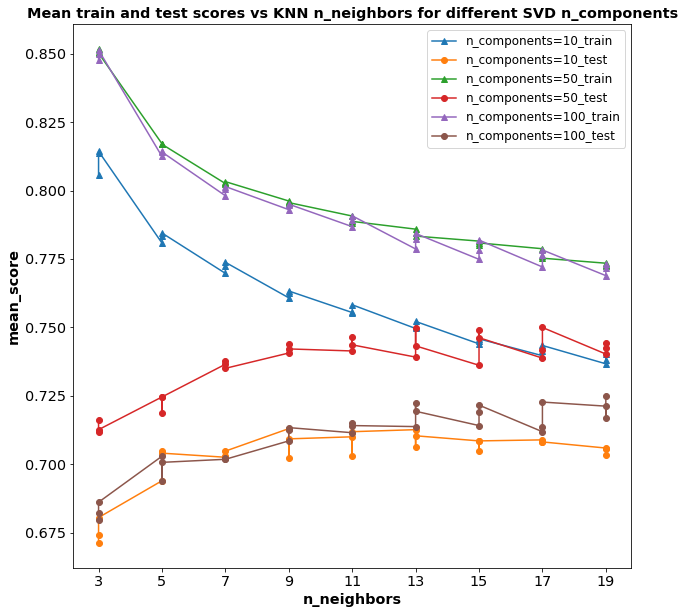

In [25]:
plt.figure(figsize=(10,10))
plt.xticks(range(3,20,2),range(3,20,2))

for n_comp in params['svd__n_components']:
    plt.plot(gs_pipe_df['param_knn__n_neighbors'][gs_pipe_df['param_svd__n_components'] == n_comp], 
             gs_pipe_df['mean_train_score'][gs_pipe_df['param_svd__n_components'] == n_comp],
             '-^',label='n_components={}_train'.format(n_comp))
    plt.plot(gs_pipe_df['param_knn__n_neighbors'][gs_pipe_df['param_svd__n_components'] == n_comp], 
             gs_pipe_df['mean_test_score'][gs_pipe_df['param_svd__n_components'] == n_comp],
             '-o',label='n_components={}_test'.format(n_comp))
    plt.xlabel('n_neighbors')
    plt.ylabel('mean_score')
    plt.title('Mean train and test scores vs KNN n_neighbors for different SVD n_components')
    plt.legend()

In [13]:
sum(10*gs_pipe_df['mean_fit_time']+10*gs_pipe_df['mean_score_time'])/60

66.616353535652166

In [26]:
knn_model.classes_

array(['Aerospace_engineering', 'Artificial_intelligence',
       'Bioinformatics', 'Biological_engineering', 'Business_intelligence',
       'Computational_statistics', 'Data_analysis',
       'Electrical_engineering', 'Information_science', 'Machine_learning',
       'Mechanical_engineering', 'Operations_research', 'Robotics',
       'Software_engineering', 'Systems_engineering'], dtype=object)

In [27]:
knn_model.predict_proba(preprocess_search_text(wikipedia.page(pageid=13494976).content,lsa_vectorizer,fit_svd))

array([[ 0.        ,  0.70588235,  0.        ,  0.        ,  0.05882353,
         0.        ,  0.        ,  0.        ,  0.        ,  0.11764706,
         0.        ,  0.05882353,  0.05882353,  0.        ,  0.        ]])

## Performing predictions on uncollected articles with the trained model

In [17]:
uncollected_articles_dict = pickle.loads(r.get('uncollected_articles'))
lsa_vectorizer = pickle.loads(r.get('vectorizer'))
fit_svd = pickle.loads(r.get('fit_svd'))
knn_model = pickle.loads(r.get('knn_model'))
pageid_title_df = pickle.loads(r.get('pageid_title_df'))

new_article_ids = []
for val in uncollected_articles_dict.values():
    if len(val) != 0:
        for i in val:
            new_article_ids.append(i)

correct = []
false_pred_ids = {}
            
for artid in new_article_ids:
    article_text = wikipedia.page(pageid=artid).content
    predict_lsa = preprocess_search_text(article_text,lsa_vectorizer,fit_svd)
    title = pageid_title_df['title'][pageid_title_df['pageid'] == int(artid)].values[0]
    actual = pageid_title_df['category'][pageid_title_df['pageid'] == int(artid)].values[0]
    predicted = knn_model.predict(predict_lsa)[0]
    probabilities = knn_model.predict_proba(predict_lsa)
    max_probability = probabilities.max()
    correct.append([actual == predicted][0])
    if [actual == predicted][0] == False:
        false_pred_ids[artid] = [title,actual,predicted,max_probability]
    print("\nPage ID:", artid)
    print('Title:', title)
    print("Actual Category:", actual)
    print("Predicted Category:", predicted)
    print("Confidence Score:", round(max_probability,2))
    print("Correct prediction:", [actual == predicted][0])

print("\nTotal number of predictions:", len(correct))
print("Percent of correct predictions:", sum(correct)/len(correct))


Page ID: 13494976
Title: CALO
Actual Category: Artificial_intelligence
Predicted Category: Artificial_intelligence
Confidence Score: 0.71
Correct prediction: True

Page ID: 36298401
Title: DAYDREAMER
Actual Category: Artificial_intelligence
Predicted Category: Artificial_intelligence
Confidence Score: 0.53
Correct prediction: True

Page ID: 37394465
Title: KAoS
Actual Category: Artificial_intelligence
Predicted Category: Artificial_intelligence
Confidence Score: 0.59
Correct prediction: True

Page ID: 48834013
Title: DAVI
Actual Category: Robotics
Predicted Category: Mechanical_engineering
Confidence Score: 0.29
Correct prediction: False

Page ID: 3678414
Title: EMBOSS
Actual Category: Bioinformatics
Predicted Category: Bioinformatics
Confidence Score: 0.94
Correct prediction: True

Page ID: 14072373
Title: EMBRACE
Actual Category: Bioinformatics
Predicted Category: Bioinformatics
Confidence Score: 0.76
Correct prediction: True

Page ID: 17727869
Title: ITools Resourceome
Actual Categ

## Performing searches on the same articles and comparing to the above predictions

In [18]:
for i in false_pred_ids.keys():
    search_article_text = wikipedia.page(pageid=i).content

    vectorizer, fitted_svd, lsa = fit_svd_for_lsa(article_contents_df['clean_text'])

    search_lsa = preprocess_search_text(search_article_text,vectorizer,fitted_svd)

    top_five, top_text = five_most_similar_docs(lsa,search_lsa,article_contents_df)

    print("\n\nSearch text:\n")
    print("Title:", false_pred_ids[i][0])
    print("Actual Category:", false_pred_ids[i][1])
    print("Predicted Category:", false_pred_ids[i][2])
    print("Confidence Score:", false_pred_ids[i][3])
    print("Introduction:", search_article_text.split('\n',1)[0])

    print("\n")
    print("The top 5 related articles are the following:\n")
    print(top_five[['category','title']],"\n\n")

    print("The text from the top related article is below:\n")
    print("Title:", top_text[['title']][0],"\n")
    print("Category:", top_text[['category']][0],"\n")
    print("Website: https://en.wikipedia.org/wiki/{}".format(re.sub('\s','_',top_text[['title']][0])),"\n")
    print("Introduction:", top_text[['clean_text']][0].split('\n',1)[0]) 



Search text:

Title: DAVI
Actual Category: Robotics
Predicted Category: Mechanical_engineering
Confidence Score: 0.294117647059
Introduction: The Dutch Automated Vehicle Initiative (DAVI) is a research and demonstration initiative developing automated vehicles for use on public roads.


The top 5 related articles are the following:

                    category              title
726                 Robotics     Autonomous car
729                 Robotics  Autonomous Things
2403  Mechanical_engineering     Railworthiness
763                 Robotics    LUTZ Pathfinder
2305  Mechanical_engineering      Drive by wire 


The text from the top related article is below:

Title: Autonomous car 

Category: Robotics 

Website: https://en.wikipedia.org/wiki/Autonomous_car 

Introduction: An autonomous car (also known as a driverless car, auto, self-driving car, robotic car) is a vehicle that is capable of sensing its environment and navigating without human input. Many such vehicles are being

In [14]:
gs_pipe_df[gs_pipe_df['param_tfidf__min_df'] == 1][gs_pipe_df['param_svd__n_components'] == 100].sort_values('rank_test_score').T

,78,60,51,69,42,33,15,24,6
mean_fit_time,7.48888,6.47983,6.4963,6.54659,6.49409,6.5012,6.67744,6.71704,7.02309
mean_score_time,0.543584,0.457179,0.457311,0.462238,0.45981,0.457713,0.471525,0.477963,0.504009
mean_test_score,0.721269,0.714179,0.713806,0.71194,0.711567,0.708582,0.702985,0.701866,0.679851
mean_train_score,0.768927,0.774875,0.778661,0.772088,0.786814,0.793012,0.812438,0.798087,0.847671
param_knn__n_neighbors,19,15,13,17,11,9,5,7,3
param_svd__n_components,100,100,100,100,100,100,100,100,100
param_tfidf__min_df,1,1,1,1,1,1,1,1,1
params,"{'knn__n_neighbors': 19, 'svd__n_components': ...","{'knn__n_neighbors': 15, 'svd__n_components': ...","{'knn__n_neighbors': 13, 'svd__n_components': ...","{'knn__n_neighbors': 17, 'svd__n_components': ...","{'knn__n_neighbors': 11, 'svd__n_components': ...","{'knn__n_neighbors': 9, 'svd__n_components': 1...","{'knn__n_neighbors': 5, 'svd__n_components': 1...","{'knn__n_neighbors': 7, 'svd__n_components': 1...","{'knn__n_neighbors': 3, 'svd__n_components': 1..."
rank_test_score,28,35,37,44,47,52,65,71,79
split0_test_score,0.753731,0.742537,0.735075,0.753731,0.742537,0.716418,0.712687,0.708955,0.66791
